In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import fdrcorrection
from sklearn.decomposition import PCA
from reframed import load_cbmodel

## Load data and metadata

In [2]:
data = pd.read_csv('../datasets/transcriptomics/yang_2011/E-GEOD-27447-A-AFFY-141-normalized-expressions.tsv', sep='\t')

In [3]:
mdata = pd.read_csv('../datasets/transcriptomics/yang_2011/E-GEOD-27447-experiment-design.tsv', sep='\t', usecols=[0,2])

## PCA plot

In [4]:
healthy = mdata[mdata['Sample Characteristic[clinical information]'] == 'non-triple negative breast cancer tumor']['Assay']
disease = mdata[mdata['Sample Characteristic[clinical information]'] == 'triple negative breast cancer tumor']['Assay']

In [5]:
X = data.iloc[:,3:].T
pca = PCA(n_components=2)
Y = pca.fit_transform(X)
df = pd.DataFrame(Y, index=data.columns[3:])

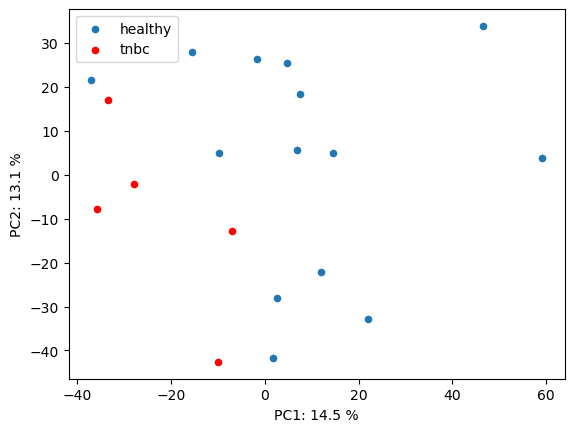

In [20]:
ax = df.loc[healthy,:].plot.scatter(0, 1)
df.loc[disease,:].plot.scatter(0, 1, color='r', ax=ax)
ax.set_xlabel(f'PC1: {100*pca.explained_variance_ratio_[0]:.1f} %')
ax.set_ylabel(f'PC2: {100*pca.explained_variance_ratio_[1]:.1f} %')
ax.legend(['healthy', 'tnbc'])
plt.savefig('/Users/daniel/Downloads/pca1.png', dpi=100)

## Vulcano plot

In [7]:
data['log2_FC'] = data.loc[:, disease].mean(axis=1) - data.loc[:, healthy].mean(axis=1)
data['p'] = data.apply(lambda x: ttest_ind(list(x[healthy]), list(x[disease]))[1], axis=1)
data['q'] = fdrcorrection(data['p'])[1]
data['log10_q'] = -np.log10(data['q'])

<Axes: xlabel='log2_FC', ylabel='log10_q'>

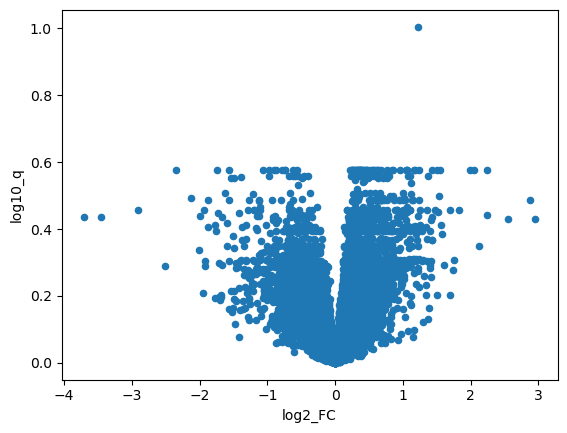

In [8]:
data.plot.scatter('log2_FC', 'log10_q')

## Pathway enrichment analysis

In [9]:
# stopping with FDR correction, otherwise no hits !!!

over_exp = list(data.query('log2_FC > 1 and p < 0.01')['Gene ID'])
under_exp = list(data.query('log2_FC < -1 and p < 0.01')['Gene ID'])

In [10]:
from gprofiler import GProfiler

gp = GProfiler(return_dataframe=True)
over = gp.profile(organism='hsapiens', query=over_exp)
under = gp.profile(organism='hsapiens', query=under_exp)

In [11]:
over.query('source == "KEGG" or source == "REAC"').sort_values('p_value').head(10)

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
44,KEGG,KEGG:04662,B cell receptor signaling pathway,0.001179,True,B cell receptor signaling pathway,81,34,5,8484,0.147059,0.061728,query_1,[KEGG:00000]
61,KEGG,KEGG:04062,Chemokine signaling pathway,0.006991,True,Chemokine signaling pathway,190,34,6,8484,0.176471,0.031579,query_1,[KEGG:00000]
84,KEGG,KEGG:04640,Hematopoietic cell lineage,0.035205,True,Hematopoietic cell lineage,92,34,4,8484,0.117647,0.043478,query_1,[KEGG:00000]


In [12]:
under.query('source == "KEGG" or source == "REAC"').sort_values('p_value').head(10)

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents


## Metabolic reactions

In [13]:
recon3 = load_cbmodel('../mappings/Recon3D.xml.gz')

In [14]:
entrez = pd.read_csv('../mappings/Homo_sapiens.GRCh38.113.entrez.tsv', sep='\t', usecols=[0,3], header=0, dtype=str, names=['Gene ID', 'entrez'])

In [15]:
gpr = recon3.gene_to_reaction_lookup()
gpr = pd.DataFrame(gpr.items(), columns=['gene', 'reactions'])
gpr['entrez'] = gpr['gene'].apply(lambda x: x.split('_')[1])
gpr = pd.merge(entrez, gpr, on='entrez')

def merge_and_sort(x):
    return sorted({z for y in x for z in y})
    
gpr = gpr.groupby('Gene ID', as_index=False).agg({'reactions': merge_and_sort})

In [16]:
merged = pd.merge(data[['Gene ID', 'Gene Name', 'log2_FC', 'p', 'q']], gpr, on='Gene ID')

### up-regulated

In [17]:
up_rxns = merge_and_sort(merged.query('log2_FC > 1 and p < 0.01')['reactions'])

for r_id in up_rxns:
    print(recon3.reactions[r_id].name)
    recon3.print_reaction(r_id, use_names=True)
    print()

UDP-GlcNAc:betaGal beta-1,3-N-acetylglucosaminyltransferase 5
R_B3GNT51g: Galactosyl glucosyl ceramide + UDP-N-acetyl-D-glucosamine --> (Gal)1 (Glc)1 (GlcNAc)1 (Cer)1 + H+ + UDP C9H11N2O12P2

HMR 0765
R_HMR_0765: Glucocerebroside (homo sapiens) + UDPgalactose --> Galactosyl glucosyl ceramide + H+ + UDP C9H11N2O12P2

Alpha-N-Acetylneuraminate Alpha-2, 8-Sialyltransferase
R_HMR_0814: Monosialylgalactosylgloboside + UDP-N-acetyl-D-galactosamine --> V3(Neuac)2-Gb5Cer ((Gal)3 (GalNAc)1 (Glc)1 (Neu5Ac)2 (Cer)1) + UDP C9H11N2O12P2

Alpha-N-Acetylneuraminate Alpha-2, 8-Sialyltransferase
R_HMR_0841: CMP-N-acetylneuraminate + Ganglioside GM3 (homo sapiens) --> CMP C9H12N3O8P + GD3 (homo sapiens) + H+

Alpha-N-Acetylneuraminate Alpha-2, 8-Sialyltransferase
R_HMR_0851: CMP-N-acetylneuraminate + Ganglioside GM2 (homo sapiens) --> CMP C9H12N3O8P + GD2 (homo sapiens) + H+

Alpha-N-Acetylneuraminate Alpha-2, 8-Sialyltransferase
R_HMR_0852: CMP-N-acetylneuraminate + Ganglioside GM1 (homo sapiens) --> C

### down-regulated

In [18]:
down_rxns = merge_and_sort(merged.query('log2_FC < -1 and p < 0.01')['reactions'])

for r_id in down_rxns:
    print(recon3.reactions[r_id].name)
    recon3.print_reaction(r_id, use_names=True)
    print()

Transport of 11-Cis-Eicosenoate, Active
R_CE2510ABCt: 11-cis-eicosenoate + ATP C10H12N5O13P3 + H2O H2O --> 11-cis-eicosenoate + ADP C10H12N5O10P2 + H+ + Phosphate

Transport of 15-Hydroxy- (8Z, 11Z, 13E)-Eicosatrienoate, Active
R_CE2537ABCt: 15-hydroxy-(8Z,11Z,13E)-eicosatrienoate + ATP C10H12N5O13P3 + H2O H2O --> 15-hydroxy-(8Z,11Z,13E)-eicosatrienoate + ADP C10H12N5O10P2 + H+ + Phosphate

Transport of Decanoate (n-C10:0) into the cell by diffusion
R_DCATDc: Decanoate (n-C10:0) <-> Decanoate (n-C10:0)

Deamino-NAD+ nucleotidohydrolase
R_DNADDP: Deamino-NAD+ + H2O H2O <-> AMP C10H12N5O7P + 2.0 H+ + Nicotinate D-ribonucleotide

Absorption Or Uptake of 13-Docosenoic Acid into Cells
R_DOCO13EFATP: ATP C10H12N5O13P3 + Coenzyme A + 13Z)-13-docosenoic acid --> AMP C10H12N5O7P + 13-Docosenoyl Coenzyme A + Diphosphate

Pyrophasphatase (dephospho-CoA)
R_DPCOAPP: Dephospho-CoA + H2O H2O <-> AMP C10H12N5O7P + 2.0 H+ + Pantetheine 4'-phosphate

Fatty acid transport via diffusion
R_ELAIDt: Elaidic 